In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

from cvxopt import matrix, solvers

from sklearn import datasets
from sklearn import model_selection
from sklearn.datasets import make_circles
import plotly.graph_objects as go
from numba import njit

import neal

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    auc
)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import Classic_SVM_CVXOPT_Linear as CL
import Classic_SVM_CVXOPT_Gaussian as CG
import Quantum_SVM_Linear_neal as QL
import Quantum_SVM_Gaussian_neal as QG

import os
import time
import pandas as pd

In [2]:
SAVE_DIR = r"C:\Users\cotjq\OneDrive\Desktop\python_code\Quantum Computing Lab\SVM_Data"
os.makedirs(SAVE_DIR, exist_ok=True)

In [3]:
def run_single_experiment(run_id):
    rows = []



    B_list = [5]*30
    K_list = [3]*30
    xi_list = [1]*30
    gamma_list = [g/10 for g in range(30)]

    for i in range(len(gamma_list)):
        B = B_list[i]; K = K_list[i]; xi = xi_list[i]; gamma = gamma_list[i]

        # ---- C 계산
        C = 0
        for k in range(1, K+1):
            C += B**k

        # =======================
        # Classic SVM
        # =======================
        P, q, G, h, A, b, K_train_train = CG.Solver_Parameter(N_train, X_train, y_train, gamma, C)
        sol = CG.Solver_SVM(P, q, G, h, A, b)

        alpha_c = np.array(sol["x"]).reshape(-1)

        C_acc_train, C_auroc_train, C_auprc_train, C_scores_train = CG.evaluate_train(
            y_train, alpha_c, K_train_train, C
        )

        C_acc_test, C_auroc_test, C_auprc_test = CG.evaluate_test(
            y_test,
            CG.Test_evlauation(X_train, X_test, y_train, alpha_c, K_train_train, gamma, C)
        )

        C_gap_acc, C_gap_auroc, C_gap_auprc = CG.Evaluate_Overfitting(
            C_acc_train, C_acc_test, C_auroc_train, C_auroc_test, C_auprc_train, C_auprc_test
        )

        C_loss_train, C_loss_test = CG.Hinge_Loss(
            X_train, X_test, y_train, y_test, alpha_c, K_train_train, C_scores_train, gamma, C
        )
        C_hinge_gap = C_loss_test - C_loss_train

        # =======================
        # Quantum SVM (top-k 중 best)
        # =======================
        K_train_train_q, Q = QG.Q_metric(N_train, X_train, y_train, B, K, xi, gamma)
        sol_q = QG.neal_Solver(Q)

        top_k = min(len(sol_q), 20)

        Q_acc_test_list = []
        Q_auroc_test_list = []
        Q_auprc_test_list = []
        Q_gap_acc_list = []
        Q_gap_auroc_list = []
        Q_gap_auprc_list = []
        Q_loss_train_list = []
        Q_loss_test_list = []

        for n_th in range(top_k):
            x_opt, energy = QG.Solution(sol_q, top_k, n_th)
            alpha_q = QG.alpha_value(N_train, x_opt, B, K)

            Q_acc_train, Q_auroc_train, Q_auprc_train, Q_scores_train = QG.evaluate_train(
                y_train, alpha_q, K_train_train_q, C
            )
            Q_acc_test, Q_auroc_test, Q_auprc_test = QG.evaluate_test(
                y_test,
                QG.Test_evlauation(X_train, X_test, y_train, alpha_q, K_train_train_q, gamma, C)
            )

            Q_gap_acc, Q_gap_auroc, Q_gap_auprc = QG.Evaluate_Overfitting(
                Q_acc_train, Q_acc_test, Q_auroc_train, Q_auroc_test, Q_auprc_train, Q_auprc_test
            )

            Q_loss_train, Q_loss_test = QG.Hinge_Loss(
                X_train, X_test, y_train, y_test, alpha_q, K_train_train_q, Q_scores_train, gamma, C
            )

            Q_acc_test_list.append(Q_acc_test)
            Q_auroc_test_list.append(Q_auroc_test)
            Q_auprc_test_list.append(Q_auprc_test)
            Q_gap_acc_list.append(Q_gap_acc)
            Q_gap_auroc_list.append(Q_gap_auroc)
            Q_gap_auprc_list.append(Q_gap_auprc)
            Q_loss_train_list.append(Q_loss_train)
            Q_loss_test_list.append(Q_loss_test)

        # best-of-topK 요약값 (비어있을 경우 대비)
        if Q_acc_test_list:
            Q_acc_test_max = max(Q_acc_test_list)
            Q_auroc_test_max = max(Q_auroc_test_list)
            Q_auprc_test_max = max(Q_auprc_test_list)

            Q_gap_acc_max = max(Q_gap_acc_list)
            Q_gap_auroc_max = max(Q_gap_auroc_list)
            Q_gap_auprc_max = max(Q_gap_auprc_list)

            idx_min = int(np.argmin(Q_loss_train_list))  # train hinge 최소 기준
            Q_hinge_gap_min = Q_loss_test_list[idx_min] - Q_loss_train_list[idx_min]
        else:
            Q_acc_test_max = Q_auroc_test_max = Q_auprc_test_max = np.nan
            Q_gap_acc_max = Q_gap_auroc_max = Q_gap_auprc_max = np.nan
            Q_hinge_gap_min = np.nan

        rows.append({
            "run": run_id,
            "i": i,
            "B": B, "K": K, "xi": xi, "gamma": gamma, "C": C,

            "C_acc_train": C_acc_train, "C_acc_test": C_acc_test, "C_gap_acc": C_gap_acc,
            "C_auroc_train": C_auroc_train, "C_auroc_test": C_auroc_test, "C_gap_auroc": C_gap_auroc,
            "C_auprc_train": C_auprc_train, "C_auprc_test": C_auprc_test, "C_gap_auprc": C_gap_auprc,
            "C_hinge_gap": C_hinge_gap,

            "Q_acc_test_max": Q_acc_test_max,
            "Q_auroc_test_max": Q_auroc_test_max,
            "Q_auprc_test_max": Q_auprc_test_max,
            "Q_gap_acc_max": Q_gap_acc_max,
            "Q_gap_auroc_max": Q_gap_auroc_max,
            "Q_gap_auprc_max": Q_gap_auprc_max,
            "Q_hinge_gap_min": Q_hinge_gap_min,
        })

    return rows

In [ ]:
N_RUNS = 50
all_rows = []

for i in range(10):
    n_train = 50
    X, Y = make_circles(n_samples=200, noise=0.1, random_state=i)
    X_train = X[:n_train, :]
    X_test  = X[n_train:, :]
    y_train = 2 * Y[:n_train] - 1mf.dms.nfndlksdlkfsnddnfndlndjfkkfm,,nddd;afk
    y_test  = 2 * Y[n_train:] - 1

    N_train = X_train.shape[0]

    for run_id in range(1, N_RUNS + 1):
        print(f"[RUN {run_id}/{N_RUNS}]")
        all_rows.extend(run_single_experiment(run_id))

    df = pd.DataFrame(all_rows)

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"SVM_experiment_runs{N_RUNS}_{timestamp}.csv"
    save_path = os.path.join(SAVE_DIR, filename)

    df.to_csv(save_path, index=False, encoding="utf-8-sig")
    print(f"Saved results to:\n{save_path}")


[RUN 1/50]
     pcost       dcost       gap    pres   dres
 0: -3.8750e+03 -5.9991e+04  6e+04  3e-14  1e-13
 1: -4.3069e+03 -7.7896e+03  3e+03  6e-14  2e-13
 2: -7.1018e+03 -7.5299e+03  4e+02  2e-13  2e-13
 3: -7.1297e+03 -7.1344e+03  5e+00  6e-14  8e-14
 4: -7.1300e+03 -7.1300e+03  5e-02  2e-16  1e-13
 5: -7.1300e+03 -7.1300e+03  5e-04  2e-16  4e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.2331e+02 -9.0917e+04  9e+04  9e-14  1e-13
 1: -1.1288e+03 -1.8452e+04  2e+04  9e-14  9e-14
 2: -2.3280e+03 -6.2014e+03  4e+03  4e-14  8e-14
 3: -3.1611e+03 -4.4645e+03  1e+03  7e-14  1e-13
 4: -3.6059e+03 -3.8789e+03  3e+02  2e-13  1e-13
 5: -3.7073e+03 -3.7615e+03  5e+01  3e-14  1e-13
 6: -3.7310e+03 -3.7380e+03  7e+00  9e-14  2e-13
 7: -3.7338e+03 -3.7345e+03  7e-01  2e-13  2e-13
 8: -3.7341e+03 -3.7341e+03  8e-03  2e-13  2e-13
 9: -3.7341e+03 -3.7341e+03  8e-05  1e-14  1e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.9517e+

In [ ]:
Data = pd.read_csv(r"C:\Users\cotjq\OneDrive\Desktop\python_code\Quantum Computing Lab\SVM_Data\SVM_experiment_runs100_20260124_064301.csv")

In [ ]:
N_RUNS = 100

In [ ]:
gamma = []

C_gap_acc = []
C_gap_auroc = []
C_gap_auprc = []
C_hinge_gap = []

Q_gap_acc_max = []
Q_gap_auroc_max = []
Q_gap_auprc_max = []
Q_hinge_gap_min = []

In [ ]:
gamma_list = Data["gamma"]

C_gap_acc_list = Data["C_gap_acc"]
C_gap_auroc_list = Data["C_gap_auroc"]
C_gap_auprc_list = Data["C_gap_auprc"]
C_hinge_gap_list = Data["C_hinge_gap"]

Q_gap_acc_max_list = Data["Q_gap_acc_max"]
Q_gap_auroc_max_list = Data["Q_gap_auroc_max"]
Q_gap_auprc_max_list = Data["Q_gap_auprc_max"]
Q_hinge_gap_min_list = Data["Q_hinge_gap_min"]

In [ ]:
for i in range(N_RUNS):
    gamma.append(gamma_list[30*i: 30*(i+1)])

    C_gap_acc.append(C_gap_acc_list[30*i: 30*(i+1)])
    C_gap_auroc.append(C_gap_auroc_list[30*i: 30*(i+1)])
    C_gap_auprc.append(C_gap_auprc_list[30*i: 30*(i+1)])
    C_hinge_gap.append(C_hinge_gap_list[30*i: 30*(i+1)])

    Q_gap_acc_max.append(Q_gap_acc_max_list[30*i: 30*(i+1)])
    Q_gap_auroc_max.append(Q_gap_auroc_max_list[30*i: 30*(i+1)])
    Q_gap_auprc_max.append(Q_gap_auprc_max_list[30*i: 30*(i+1)])
    Q_hinge_gap_min.append(Q_hinge_gap_min_list[30*i: 30*(i+1)])

gamma = gamma[0].T
C_gap_acc = C_gap_acc[0]
C_gap_auroc = C_gap_auroc[0]
C_gap_auprc = C_gap_auprc[0]
C_hinge_gap = C_hinge_gap[0]

Q_gap_acc_max = np.array(Q_gap_acc_max)
Q_gap_auroc_max = np.array(Q_gap_auroc_max)
Q_gap_auprc_max = np.array(Q_gap_auprc_max)
Q_hinge_gap_min = np.array(Q_hinge_gap_min)

In [ ]:
print(C_hinge_gap)

0     0.000000
1     0.123296
2     0.258079
3     0.262452
4     0.253245
5     0.256247
6     0.277330
7     0.307483
8     0.356782
9     0.397673
10    0.464246
11    0.515712
12    0.569235
13    0.606199
14    0.641196
15    0.690851
16    0.755955
17    0.773294
18    0.775445
19    0.779826
20    0.784589
21    0.788999
22    0.788070
23    0.785971
24    0.783668
25    0.781463
26    0.794701
27    0.810228
28    0.826622
29    0.843783
Name: C_hinge_gap, dtype: float64


In [ ]:
Q_gap_acc_max_M = Q_gap_acc_max.max(axis=0)
Q_gap_auroc_max_M = Q_gap_auroc_max.max(axis=0)
Q_gap_auprc_max_M = Q_gap_auprc_max.max(axis=0)
Q_hinge_gap_min_M = Q_hinge_gap_min.max(axis=0)

Q_gap_acc_max_mean = Q_gap_acc_max.mean(axis=0)
Q_gap_auroc_max_mean = Q_gap_auroc_max.mean(axis=0)
Q_gap_auprc_max_mean = Q_gap_auprc_max.mean(axis=0)
Q_hinge_gap_min_mean = Q_hinge_gap_min.mean(axis=0)

Q_gap_acc_max_m = Q_gap_acc_max.min(axis=0)
Q_gap_auroc_max_m = Q_gap_auroc_max.min(axis=0)
Q_gap_auprc_max_m = Q_gap_auprc_max.min(axis=0)
Q_hinge_gap_min_m = Q_hinge_gap_min.min(axis=0)

In [ ]:
Acc_lower = Q_gap_acc_max_m
Acc_upper = Q_gap_acc_max_M

Auroc_lower = Q_gap_auroc_max_m
Auroc_upper = Q_gap_auroc_max_M

Auprc_lower = Q_gap_auprc_max_m
Auprc_upper = Q_gap_auprc_max_M

Hinge_lower = Q_hinge_gap_min_m
Hinge_upper = Q_hinge_gap_min_M

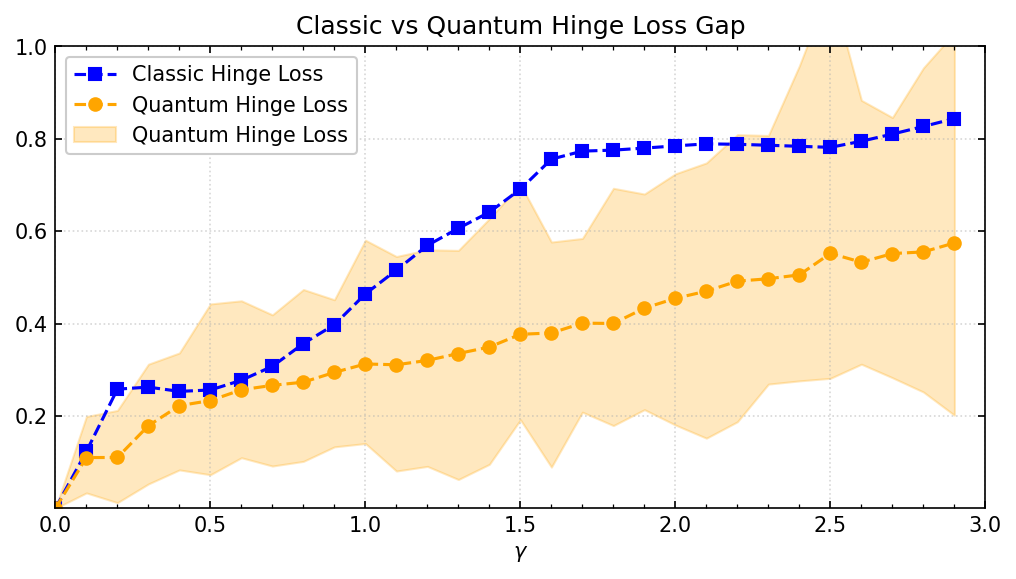

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

ax.plot(gamma, C_hinge_gap, "s--", color = "blue", label = "Classic Hinge Loss")
ax.plot(gamma, Q_hinge_gap_min_mean, "o--", color = "orange", label = "Quantum Hinge Loss")

ax.fill_between(
    gamma,
    Hinge_lower,
    Hinge_upper,
    color="orange",
    alpha=0.25,
    label = "Quantum Hinge Loss"
)

ax.set_title("Classic vs Quantum Hinge Loss Gap")
ax.set_ylim(1e-6, 1)
ax.set_xlabel(r"$\gamma$")

# x축 범위 (0~3만 쓰는 거면 0~3만 남김)
ax.set_xlim(0, 3)

# x축: 0.5는 큰 눈금(major), 0.1은 작은 눈금(minor)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# 격자: 큰 눈금 위치에만, 점선, 투명도 50%
ax.grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)

# 위/오른쪽에도 눈금 + 안쪽 방향
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax.legend(loc="upper left", framealpha=1)

plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:40: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\g'
<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:40: SyntaxWarning: invalid escape sequence '\g'
C:\Users\cotjq\AppData\Local\Temp\ipykernel_29276\1078238296.py:12: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_xlabel(u"${\gamma}$")
C:\Users\cotjq\AppData\Local\Temp\ipykernel_29276\1078238296.py:26: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_xlabel(u"${\gamma}$")
C:\Users\cotjq\AppData\Local\Temp\ipykernel_29276\1078238296.py:40: SyntaxWarning: invalid escape sequence '\g'
  axes[2].set_xlabel(u"${\gamma}$")


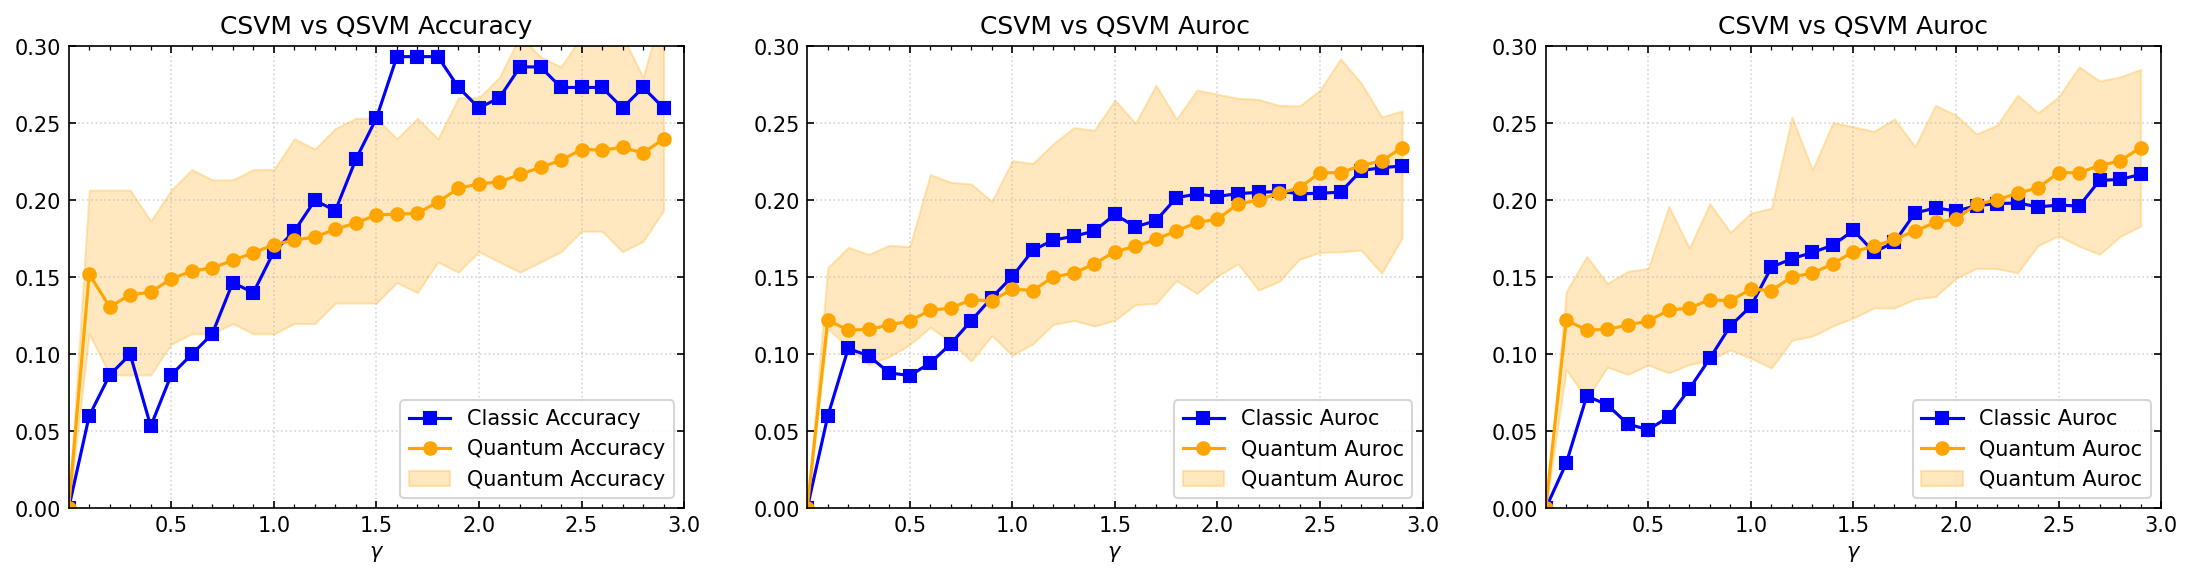

In [ ]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 4),   # 전체 크기 고정
    dpi=150,
    sharex=True
)

axes[0].plot(gamma, C_gap_acc, "s-", color = "blue", label = "Classic Accuracy")
axes[0].plot(gamma, Q_gap_acc_max_mean, "o-", color = "orange", label = "Quantum Accuracy")
axes[0].fill_between(gamma, Acc_lower, Acc_upper, color = "orange", label = "Quantum Accuracy", alpha = 0.25)
axes[0].set_title("CSVM vs QSVM Accuracy")
axes[0].set_xlabel(u"${\gamma}$")
axes[0].set_ylim(0, 0.3)
axes[0].set_xlim(1e-6, 3)
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(0.5))
axes[0].xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axes[0].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[0].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[0].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[0].legend(loc = "lower right")

axes[1].plot(gamma, C_gap_auroc, "s-", color = "blue", label = "Classic Auroc")
axes[1].plot(gamma, Q_gap_auprc_max_mean, "o-", color = "orange", label = "Quantum Auroc")
axes[1].fill_between(gamma, Auroc_lower, Auroc_upper, color = "orange", label = "Quantum Auroc", alpha = 0.25)
axes[1].set_title("CSVM vs QSVM Auroc")
axes[1].set_xlabel(u"${\gamma}$")
axes[1].set_ylim(0, 0.3)
axes[1].set_xlim(1e-6, 3)
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(0.5))
axes[1].xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axes[1].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[1].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[1].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[1].legend(loc = "lower right")

axes[2].plot(gamma, C_gap_auprc, "s-", color = "blue", label = "Classic Auroc")
axes[2].plot(gamma, Q_gap_auprc_max_mean, "o-", color = "orange", label = "Quantum Auroc")
axes[2].fill_between(gamma, Auprc_lower, Auprc_upper, color = "orange", label = "Quantum Auroc", alpha = 0.25)
axes[2].set_title("CSVM vs QSVM Auroc")
axes[2].set_xlabel(u"${\gamma}$")
axes[2].set_ylim(0, 0.3)
axes[2].set_xlim(1e-6, 3)
axes[2].xaxis.set_major_locator(mticker.MultipleLocator(0.5))
axes[2].xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axes[2].xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
axes[2].grid(which='major', linestyle=':', linewidth=0.8, alpha=0.5)
axes[2].tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[2].legend(loc = "lower right")